Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
<class 'pandas.core.frame.DataFrame'>
Index: 461820 entries, 0 to 5476998
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          461820 non-null  int64  
 1   date           461820 non-null  object 
 2   time           461820 non-null  object 
 3   geo_lat        461820 non-null  float64
 4   geo_lon        461820 non-null  float64
 5   building_type  461820 non-null  int64  
 6   level          461820 non-null  int64  
 7   levels         461820 non-null  int64  
 8   rooms          461820 non-null  int64  
 9   area           461820 non-null  float64
 10  kitchen_area   461820 non-null  float64
 11  object_type    461820 non-null  int64  
dtypes: float64(4), int64(6),

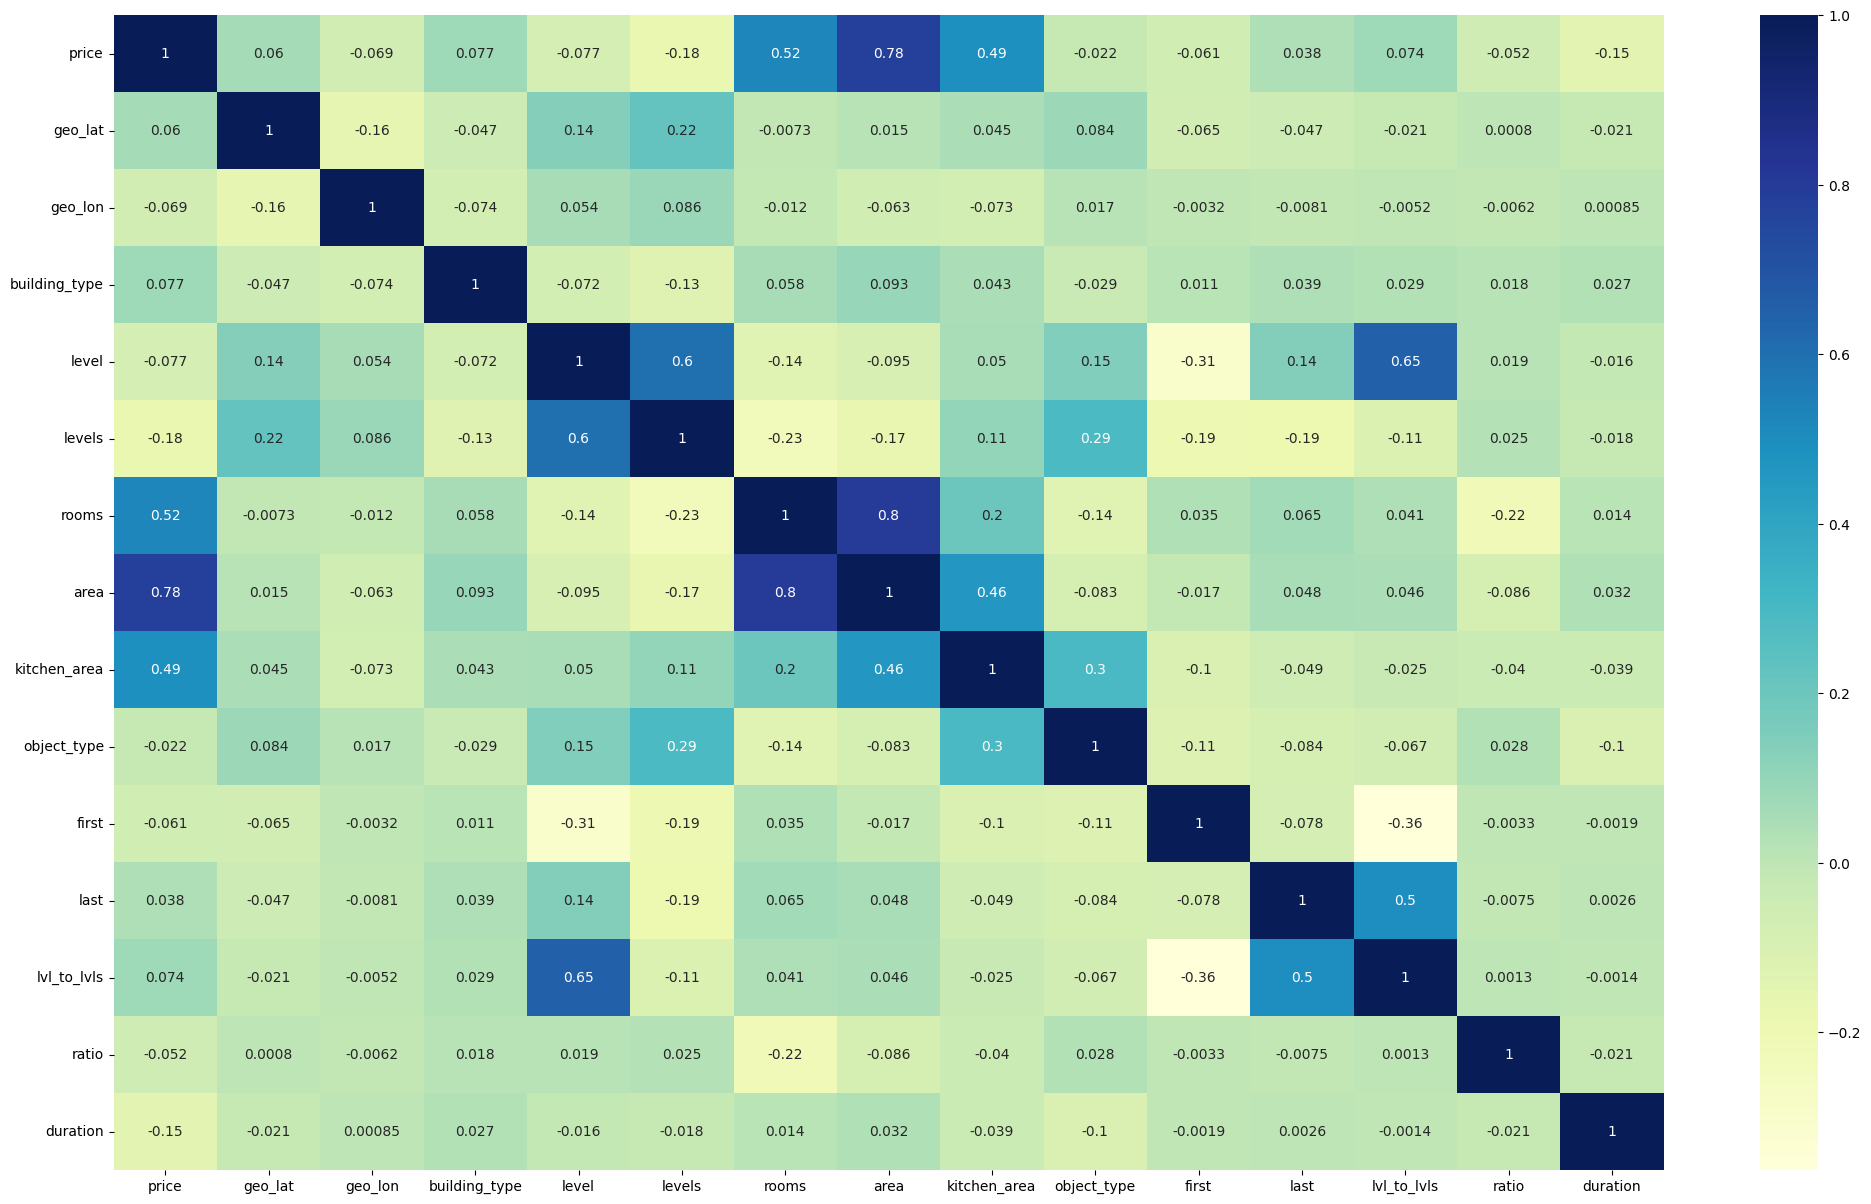

             Ridge      XGBoost
R2           0.628        0.789
MAE    1847854.100  1166999.772
RMSLE        0.536        0.243


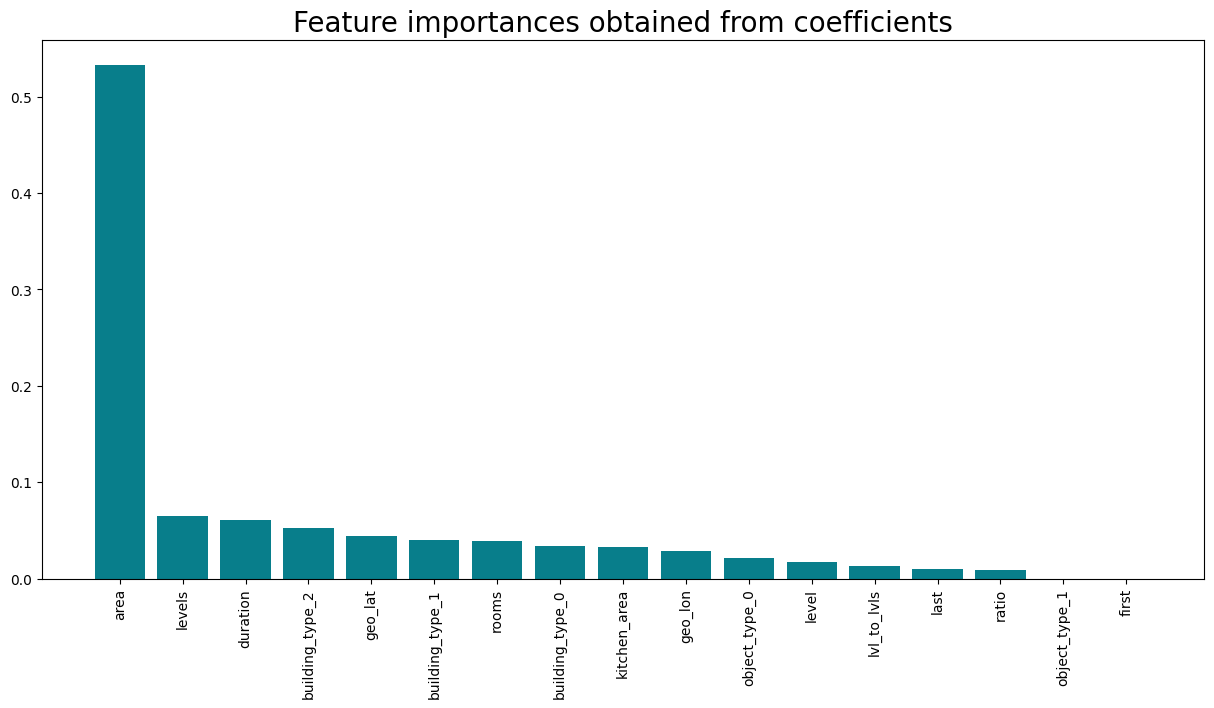

Predicted Price for the new apartment: [4771796.]


In [5]:
# Установка необходимых библиотек
!pip install seaborn
!pip install xgboost
!pip install category_encoders==2.6.0

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
import xgboost as xgb
import category_encoders as ce
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных с фильтрацией по региону (СПб)
df = pd.read_csv('E:/ml_Dzyuin/Практика_11/all_v2.csv')
df = df[df['region'] == 2661]
df.drop('region', axis=1, inplace=True)
df.info()

# Фильтрация данных по условиям
df = df[(df['area'] >= 20) & (df['area'] <= 200)]
df = df[(df['kitchen_area'] >= 6) & (df['kitchen_area'] <= 30)]
df = df[(df['price'] >= 1500000) & (df['price'] <= 50000000)]
df.reset_index(inplace=True, drop=True)

# Замена отрицательного числа комнат на 0
df['rooms'] = df['rooms'].replace({-1: 0, -2: 0})

# Добавление новых признаков
df['first'] = np.where(df['level'] == 1, 1, 0)
df['last'] = np.where(df['level'] == df['levels'], 1, 0)
df['lvl_to_lvls'] = df['level'] / df['levels']
df['ratio'] = np.where(df['rooms'] != 0, df['kitchen_area'] / df['area'], df['area'])

# Вычисление продолжительности
df['date'] = pd.to_datetime(df['date'])
df['duration'] = (df['date'].max() - df['date']).dt.days

df.drop(['date', 'time'], axis=1, inplace=True)

# Матрица корреляции
plt.figure(figsize=(25, 15))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap="YlGnBu")
plt.show()

# Кодирование категориальных переменных
encoder = ce.BinaryEncoder(cols=['building_type', 'object_type'])
df = encoder.fit_transform(df)
df.reset_index(drop=True, inplace=True)

# Сортировка по давности объявления
df = df.sort_values(by='duration')

# Выделение результирующего показателя и удаление его из общей выборки
y = df['price']
df.drop(['price'], axis=1, inplace=True)

# Разделение выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42, shuffle=False)

# Стандартизация
scaler = StandardScaler()

# Выделение категориальных признаков
categorical = ['building_type_0', 'building_type_1', 'building_type_2', 'object_type_0', 'object_type_1', 'first', 'last']

# Создание датафрейма с категориальными признаками
df_cat_train = x_train[categorical]
df_cat_train.reset_index(drop=True, inplace=True)

df_cat_test = x_test[categorical]
df_cat_test.reset_index(drop=True, inplace=True)

# Создание датафрейма с числовыми признаками
numerical_train = x_train.drop(categorical, axis=1)
numerical_test = x_test.drop(categorical, axis=1)

# Стандартизация числовых признаков обучающей выборки
df_num_train = pd.DataFrame(scaler.fit_transform(numerical_train), columns=numerical_train.columns)
x_std_train = df_num_train.join(df_cat_train)

# Стандартизация числовых признаков выборки
df_num_test = pd.DataFrame(scaler.transform(numerical_test), columns=numerical_test.columns)
x_std_test = df_num_test.join(df_cat_test)

# Построение линейной регрессии с L2 регуляризацией
ridge = Ridge()
parameters = {"alpha": [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_regression = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regression.fit(x_std_train, y_train)

ridge = Ridge(alpha=20).fit(x_std_train, y_train)
reg_pred = ridge.predict(x_std_test)

# Модель XGBoost
xgb_r = xgb.XGBRegressor()
xgb_r.fit(x_train, y_train)
xgb_pred = xgb_r.predict(x_test)

# Функции для расчета метрик
def r2(y_true, y_pred):
    return round(r2_score(y_true, y_pred), 3)

def mae(y_true, y_pred):
    return round(mean_absolute_error(y_true, y_pred), 3)

def rmsle(y_true, y_pred):
    if any(x < 0 for x in y_pred):
        y_pred = [abs(i) for i in y_pred]
    return round(mean_squared_log_error(y_true, y_pred, squared=False), 3)

# Расчет метрик
metrics = pd.DataFrame({
    'Ridge': [r2(y_test, reg_pred), mae(y_test, reg_pred), rmsle(y_test, reg_pred)],
    'XGBoost': [r2(y_test, xgb_pred), mae(y_test, xgb_pred), rmsle(y_test, xgb_pred)]
}, index=['R2', 'MAE', 'RMSLE'])

print(metrics)

# Анализ значимых признаков
importances = pd.DataFrame({'Attribute': x_train.columns, 'Importance': xgb_r.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 7))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Скоринг нового объекта
new_apartment = np.array([[59.850103, 30.357299, 0, 0, 1, 2, 5, 1, 31.00, 6.00, 0, 1, 0, 0, 0.400000, 0.193548, 0]])
predicted_price = xgb_r.predict(new_apartment)
print("Predicted Price for the new apartment:", predicted_price)